In [3]:
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')

import numpy as np
from common.functions import *
import matplotlib.pyplot as plt
from common.optimizer import SGD

sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2/dataset')
from ptb import load_data

### RNN 계층 구현  

In [4]:
class RNN:
  def __init__(self, Wx, Wh, b):  # Wx: 입력 x에 대한 가중치, Wh: 이전 상태 h에 대한 가중치, b: 편향
    self.params = [Wx, Wh, b]   # 입력받은 Wx, Wh, b를 params에 리스트로 저장
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]  # 기울기 초기화
    self.cache = None           # 순전파 시 입력된 x, 이전 상태 h, 다음 상태 h를 저장할 cache
  
  # 순전파
  def forward(self, x, h_prev):                 # x: 입력, h_prev(h_t-1): 이전 상태
    Wx, Wh, b = self.params                     # Wx, Wh, b를 params에서 가져옴
    t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b  # h_prev, x, b를 행렬 곱하고 편향을 더해 t를 구함
    h_next = np.tanh(t)                         # tanh 함수를 통과시켜 h_next를 구함, h_t = tanh(h_t-1 * Wh + x_t * Wx + b)
    self.cache = (x, h_prev, h_next)            # x, h_prev, h_next를 cache에 저장
    return h_next                               # h_next(h_t) 반환
  
  # 역전파
  def backward(self, dh_next):        # dh_next: 출력 쪽에서 전해지는 기울기
    Wx, Wh, b = self.params           # Wx, Wh, b를 params에서 가져옴
    x, h_prev, h_next = self.cache    # cache에서 x, h_prev, h_next를 가져옴
    
    dt = dh_next * (1 - h_next ** 2)  # tanh 미분, dt = dh_next * (1 - h_next^2)
    db = np.sum(dt, axis=0)           # db = dt
    dWh = np.dot(h_prev.T, dt)        # dWh = h_prev * dt
    dh_prev = np.dot(dt, Wh.T)        # dh_prev = dt * Wh
    dWx = np.dot(x.T, dt)             # dWx = x * dt
    dx = np.dot(dt, Wx.T)             # dx = dt * Wx
    
    self.grads[0][...] = dWx          # dWx, dWh, db를 grads에 저장
    self.grads[1][...] = dWh
    
    self.grads[2][...] = db
    
    return dx, dh_prev                     # 입력 x와 이전 상태 h에 대한 기울기 dx, dh_prev 반환

In [5]:
# x dimension: 4, h dimension: 2
# w_x : 4 x 2, w_h : 2 x 2, b : 2

# RNN 클래스의 인스턴스 생성
W_x = np.random.randn(4, 2)  # 입력 x에 대한 가중치
W_h = np.random.randn(2, 2)  # 이전 상태 h에 대한 가중치
b = np.random.randn(2)       # 편향

rnn = RNN(W_x, W_h, b)
# 순전파 forward 메서드 호출
x = np.random.randn(1,4)  # 입력
print(x)
h_prev = np.random.randn(1,2)  # 이전 상태
print(h_prev)
h_next = rnn.forward(x, h_prev)
print(h_next)

print(rnn.cache)  # (x, h_prev, h_next)

# 역전파 backward 메서드 호출
dh_next = np.random.randn(2)  # 출력 쪽에서 전해지는 기울기
print(dh_next)
dx, dh_prev = rnn.backward(dh_next)
print(dx)
print(dh_prev)
print(rnn.grads)  # [dW_x, dW_h, db]

[[-1.00751938 -0.42677832  0.68071477 -1.0521159 ]]
[[ 1.10414212 -0.95186828]]
[[-0.99795991 -0.43135969]]
(array([[-1.00751938, -0.42677832,  0.68071477, -1.0521159 ]]), array([[ 1.10414212, -0.95186828]]), array([[-0.99795991, -0.43135969]]))
[-1.20395718  0.3096301 ]
[[ 0.35089753 -0.27154679 -0.13105494  0.03157246]]
[[-0.09102914 -0.07537056]]
[array([[ 0.00494426, -0.25391187],
       [ 0.00209435, -0.10755533],
       [-0.00334051,  0.1715516 ],
       [ 0.00516311, -0.26515095]]), array([[-0.00541842,  0.27826243],
       [ 0.00467116, -0.23988686]]), array([-0.00490736,  0.25201686])]


### Time RNN 계층 구현    

In [6]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):   # Wx: 입력 x에 대한 가중치, Wh: 이전 상태 h에 대한 가중치, b: 편향, stateful: 상태 유지 여부
    self.params = [Wx, Wh, b]                      # Wx, Wh, b를 params에 저장
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]  # 기울기 초기화
    self.layers = None                             # 다수의 RNN 계층을 리스트로 저장
    
    self.h, self.dh = None, None                   # h는 forward() 메서드를 불렀을 때 마지막 RNN 계층의 은닉 상태를 저장, dh는 backward() 메서드를 불렀을 때 하나 앞 블록의 은닉 상태의 기울기를 저장
    self.stateful = stateful                       # 상태 유지 여부, 만약 False라면 은닉 상태를 영행렬(모든 요소가 0인 행렬)로 초기화
    
  def set_state(self, h):                          # 은닉 상태 설정
    self.h = h                                     # h에 입력된 h를 저장
    
  def reset_state(self):                           # 은닉 상태 초기화
    self.h = None                                  # h를 None으로 초기화
  
  # 순전파
  def forward(self, xs):                           # xs: T개 분량의 시계열 데이터를 하나로 모은 것
    Wx, Wh, b = self.params                        # Wx, Wh, b를 params에서 가져옴
    N, T, D = xs.shape                             # N: 미니배치 크기, T: 시계열 데이터의 길이, D: 입력 벡터의 차원 수
    D, H = Wx.shape                                # Wx의 형상을 가져옴
    
    self.layers = []                               # RNN 계층을 저장할 리스트 layers 초기화
    hs = np.empty((N, T, H), dtype='f')            # 은닉 상태를 저장할 hs를 영행렬로 초기화
    
    if not self.stateful or self.h is None:        # 상태 유지가 False이거나 은닉 상태가 None이면
      self.h = np.zeros((N, H), dtype='f')         # 은닉 상태를 영행렬로 초기화
    
    for t in range(T):                             # T번 반복, 데이터 개수 T만큼 반복
      layer = RNN(*self.params)                    # RNN 계층 생성
      self.h = layer.forward(xs[:, t, :], self.h)  # RNN 계층의 forward 메서드 호출, 은닉 상태 구한 후 h에 저장
      hs[:, t, :] = self.h                         # hs에 계산한 은닉 상태 저장
      self.layers.append(layer)                    # RNN 계층을 layers에 추가
    
    return hs                                     # hs 반환 -> 행렬 hs에는 각 시각의 은닉 상태(h)가 저장되어 있음, 총 T개의 은닉 상태(h)가 저장되어 있음
  
  # 역전파
  def backward(self, dhs):                         # dhs: 각 시각의 은닉 상태의 기울기
    Wx, Wh, b = self.params                        # Wx, Wh, b를 params에서 가져옴
    N, T, H = dhs.shape                            # dhs의 형상을 가져옴, N: 미니배치 크기, T: 시계열 데이터의 길이, H: 은닉 상태의 차원 수
    D, H = Wx.shape                                # Wx의 형상을 가져옴
    
    dxs = np.empty((N, T, D), dtype='f')           # dxs를 영행렬로 초기화
    dh = 0                                         # dh를 0으로 초기화
    grads = [0, 0, 0]                              # grads를 0으로 초기화
    
    for t in reversed(range(T)):                   # T-1부터 0까지 반복
      layer = self.layers[t]                       # t번째 RNN 계층을 가져옴
      dx, dh = layer.backward(dhs[:, t, :] + dh)   # RNN 계층의 backward 메서드 호출, dx와 dh를 구함, dh는 이전 블록의 은닉 상태 기울기를 더함
      dxs[:, t, :] = dx                            # dxs에 dx 저장
      
      for i, grad in enumerate(layer.grads):       # layer.grads에는 dWx, dWh, db가 저장되어 있음
        grads[i] += grad                          # grads에 grad를 더함
    
    for i, grad in enumerate(grads):               # grads에 저장된 기울기를 각각 꺼내어
      self.grads[i][...] = grad                    # self.grads에 저장, 각 RNN 계층의 가중치 기울기를 모두 더한 것이 grads이므로 이를 self.grads에 저장
    
    self.dh = dh                                   # dh를 self.dh에 저장
    
    return dxs                                     # dxs 반환

In [7]:
# TimeRNN 클래스의 인스턴스 생성
N = 1 # 미니배치 크기
T = 5 # 시계열 데이터의 길이
D = 4  # 입력 벡터의 차원 수
H = 3  # 은닉 상태의 차원 수
W_x = np.random.randn(D, H)  # 입력 x에 대한 가중치
W_h = np.random.randn(H, H)  # 이전 상태 h에 대한 가중치
b = np.random.randn(H)       # 편향
print(W_x)
print(W_h)
print(b)

time_rnn = TimeRNN(W_x, W_h, b)
# 순전파 forward 메서드 호출
xs = np.random.randn(N, T, D)  # 입력
print(xs)
hs = time_rnn.forward(xs)
print(hs)                      # hs: (N, T, H), 은닉 상태의 시계열 데이터



[[-0.1467112   0.00304117 -1.51448636]
 [-0.04356993  1.06638404  0.61999271]
 [-0.49841917  0.48560109  1.0319122 ]
 [ 1.44938991 -0.16839239  0.59199169]]
[[-0.04809326  0.14912318 -0.23466471]
 [ 0.16076289  1.06380016  0.03566217]
 [ 0.99698378  2.22111557 -0.06945657]]
[-0.80749947  0.74242327  0.31804092]
[[[ 1.59850756 -0.0714816   1.13563671 -1.98752   ]
  [ 0.57576763  0.16059268 -1.30446178  0.34465988]
  [ 0.26934324  0.12673328 -0.71064272  0.36321462]
  [-0.97604689 -0.11418968 -0.10214062  2.5348975 ]
  [ 0.38429224 -0.13491219 -0.38352429 -1.04124709]]]
[[[-0.999746    0.9149669  -0.97332704]
  [-0.4811428  -0.80535716 -0.85150474]
  [-0.7292706  -0.98188895 -0.3681435 ]
  [ 0.98848695 -0.94980127  0.99718565]
  [-0.8814146   0.959589   -0.9347657 ]]]


In [8]:
# 역전파 backward 메서드 호출
dhs = np.random.randn(N, T, H)  # 각 시각의 은닉 상태의 기울기
print(dhs)
dxs = time_rnn.backward(dhs)
print(time_rnn.grads)           # [dW_x, dW_h, db], 가중치 매개변수 기울기, dW_x: 입력 x에 대한 가중치 기울기, dW_h: 이전 상태 h에 대한 가중치 기울기, db: 편향 기울기

[[[-0.67114405 -0.3053001   0.26461786]
  [ 0.06642941  1.26212145 -0.48489914]
  [-1.58546602 -0.48308994 -0.00998992]
  [ 0.74866748  1.16711631  0.68830207]
  [ 0.47397924  0.19897907 -1.78276825]]]
[array([[-0.15541398,  0.14859629, -0.12666962],
       [-0.10385399,  0.04585561, -0.00119688],
       [ 0.43384232, -0.50980995,  0.44677213],
       [-0.31810355,  0.37604893,  0.08379752]]), array([[ 0.40977142, -0.46343017,  0.00989114],
       [ 0.5056844 ,  0.24676377, -0.2945003 ],
       [ 0.69045308, -0.4058301 , -0.08507961]]), array([-0.57618341,  0.53834505, -0.27244311])]


### SimpleRNNlm 계층 구현  

In [9]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):   # idx는 단어 ID로 이루어진 배열로 idx에 해당하는 단어 벡터를 추출
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [10]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t]) # Embedding 계층의 forward 메서드 호출, 각 시각의 단어를 단어 벡터로 변환
            self.layers.append(layer) 

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [11]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [12]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss              # 손실 반환

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx

In [13]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')    # W_x의 초깃값을 Xavier 초깃값으로 설정, W_x는 입력 x에 대한 가중치
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')    # W_h의 초깃값을 Xavier 초깃값으로 설정, W_h는 이전 상태 h에 대한 가중치
        rnn_b = np.zeros(H).astype('f')                 # 편향 b는 0으로 초기화
        
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')  # afiine_W는 Xavier 초깃값으로 설정
        affine_b = np.zeros(V).astype('f')              # 편향 affine_b는 0으로 초기화

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),                         # TimeEmbedding 계층
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),  # TimeRNN 계층
            TimeAffine(affine_W, affine_b)                  # TimeAffine 계층
        ]
        self.loss_layer = TimeSoftmaxWithLoss()             # TimeSoftmaxWithLoss 계층
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)                          # 각 계층의 forward 메서드 호출
        loss = self.loss_layer.forward(xs, ts)              # TimeSoftmaxWithLoss 계층의 forward 메서드 호출, TimeEmbedding, TimeRNN, TimeAffine 순서로 호출
        return loss                                         # 손실 반환

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)                     # 각 계층의 backward 메서드 호출
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


### RNNLM 학습 코드   

In [14]:
# 하이퍼파라미터 설정
batch_size = 100    # 미니배치 크기
wordvec_size = 1000  # 단어 임베딩 차원 수
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
corpus_size = 10000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))



말뭉치 크기: 10000, 어휘 수: 2138


In [15]:
# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size) # 
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size 
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
  for iter in range(max_iters):
    # 미니배치 취득
    batch_x = np.empty((batch_size, time_size), dtype='i')
    batch_t = np.empty((batch_size, time_size), dtype='i')
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
      time_idx += 1

    # 기울기를 구하여 매개변수 갱신
    # 미니배치 학습이기 때문에, 미니배치의 손실을 구하고, 그 손실을 이용하여 기울기를 구하고, 그 기울기를 이용하여 매개변수를 갱신
    # 하나의 미니배치 학습이 끝나면 다음 미니배치 학습을 진행
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    total_loss += loss
    loss_count += 1
    

    # 퍼플렉서티 평가
    if (iter + 1) % 10 == 0:
      ppl = np.exp(total_loss / loss_count)
      print('| 에폭 %d | 반복 %d / %d | 퍼플렉서티 %.2f'
            % (epoch + 1, iter + 1, max_iters, ppl))
      ppl_list.append(float(ppl))
      total_loss, loss_count = 0, 0


| 에폭 1 | 반복 10 / 19 | 퍼플렉서티 2107.07
| 에폭 2 | 반복 10 / 19 | 퍼플렉서티 1849.93
| 에폭 3 | 반복 10 / 19 | 퍼플렉서티 986.84
| 에폭 4 | 반복 10 / 19 | 퍼플렉서티 730.48
| 에폭 5 | 반복 10 / 19 | 퍼플렉서티 647.71
| 에폭 6 | 반복 10 / 19 | 퍼플렉서티 601.56
| 에폭 7 | 반복 10 / 19 | 퍼플렉서티 568.52
| 에폭 8 | 반복 10 / 19 | 퍼플렉서티 548.16
| 에폭 9 | 반복 10 / 19 | 퍼플렉서티 532.09
| 에폭 10 | 반복 10 / 19 | 퍼플렉서티 510.39
| 에폭 11 | 반복 10 / 19 | 퍼플렉서티 498.81
| 에폭 12 | 반복 10 / 19 | 퍼플렉서티 493.06
| 에폭 13 | 반복 10 / 19 | 퍼플렉서티 486.70
| 에폭 14 | 반복 10 / 19 | 퍼플렉서티 481.56
| 에폭 15 | 반복 10 / 19 | 퍼플렉서티 475.36
| 에폭 16 | 반복 10 / 19 | 퍼플렉서티 468.62
| 에폭 17 | 반복 10 / 19 | 퍼플렉서티 463.47
| 에폭 18 | 반복 10 / 19 | 퍼플렉서티 465.83
| 에폭 19 | 반복 10 / 19 | 퍼플렉서티 456.86
| 에폭 20 | 반복 10 / 19 | 퍼플렉서티 451.84
| 에폭 21 | 반복 10 / 19 | 퍼플렉서티 452.04
| 에폭 22 | 반복 10 / 19 | 퍼플렉서티 446.08
| 에폭 23 | 반복 10 / 19 | 퍼플렉서티 450.03
| 에폭 24 | 반복 10 / 19 | 퍼플렉서티 445.76
| 에폭 25 | 반복 10 / 19 | 퍼플렉서티 441.89
| 에폭 26 | 반복 10 / 19 | 퍼플렉서티 442.95
| 에폭 27 | 반복 10 / 19 | 퍼플렉서티 439.07
| 에폭 28 | 반복 10 / 19 | 퍼플렉서티 437.61

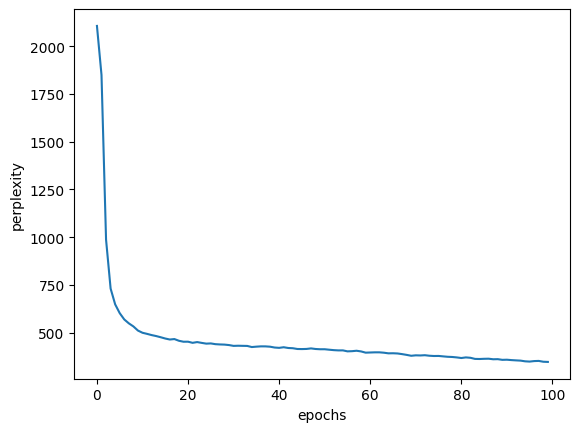

In [16]:
# 그래프 그리기


x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


In [17]:
import numpy as np
from scipy.special import softmax

# Parameters
T = 10  # Sequence length
D = 3   # Input dimension
H = 4   # Hidden state dimension
O = 3   # Output dimension
np.random.seed(42)

# Randomly initialize weights and biases
W_xh = np.random.randn(D, H)
W_hh = np.random.randn(H, H)
b_h = np.random.randn(H)
W_hy = np.random.randn(H, O)
b_y = np.random.randn(O)

# Input data (randomly generated)
x = np.random.rand(T, D)  # Input sequence
print('x',x)
y_true = np.random.randint(0, O, T)  # Ground truth labels (class indices)
print('y',y_true)

# One-hot encode y_true
y_true_one_hot = np.zeros((T, O))
y_true_one_hot[np.arange(T), y_true] = 1
print('y_true_one_hot',y_true_one_hot)

# Initialize hidden state
h_t_prev = np.zeros(H)

# Forward pass
h = np.zeros((T, H))
z = np.zeros((T, O))
y_pred = np.zeros((T, O))

for t in range(T):
    h_t = np.tanh(np.dot(x[t], W_xh) + np.dot(h_t_prev, W_hh) + b_h)
    z_t = np.dot(h_t, W_hy) + b_y
    y_t = softmax(z_t)
    print('y_t',y_t)

    h[t] = h_t
    z[t] = z_t
    y_pred[t] = y_t

    h_t_prev = h_t

# Compute Cross-Entropy Loss
loss = -np.sum(y_true_one_hot * np.log(y_pred + 1e-9)) / T
print('Loss:', loss)

x [[0.28093451 0.54269608 0.14092422]
 [0.80219698 0.07455064 0.98688694]
 [0.77224477 0.19871568 0.00552212]
 [0.81546143 0.70685734 0.72900717]
 [0.77127035 0.07404465 0.35846573]
 [0.11586906 0.86310343 0.62329813]
 [0.33089802 0.06355835 0.31098232]
 [0.32518332 0.72960618 0.63755747]
 [0.88721274 0.47221493 0.11959425]
 [0.71324479 0.76078505 0.5612772 ]]
y [2 1 2 2 0 2 2 1 1 0]
y_true_one_hot [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
y_t [0.14446895 0.43275623 0.42277482]
y_t [0.13746243 0.80426841 0.05826915]
y_t [0.20535518 0.77338275 0.02126206]
y_t [0.02371574 0.95114254 0.02514172]
y_t [0.10029468 0.8817912  0.01791412]
y_t [0.04447533 0.93544919 0.02007548]
y_t [0.1216515  0.86522911 0.01311938]
y_t [0.04054541 0.93931515 0.02013944]
y_t [0.03277509 0.94131489 0.02591002]
y_t [0.02836869 0.94476311 0.0268682 ]
Loss: 2.2839909487461503


In [18]:
# Parameters
T = 10  # Sequence length (number of words in a sentence)
D = 15  # Embedding dimension for each word
H = 5 # Hidden state dimension
V = 20 # Vocabulary size (output dimension for predictions)
np.random.seed(10) # 랜덤시드고정

# Randomly initialize weights and biases
W_xh = np.random.randn(D, H)
W_hh = np.random.randn(H, H)
b_h = np.random.randn(H)
W_hy = np.random.randn(H, V)
b_y = np.random.randn(V)

# Example input sentence represented as word embeddings (randomly initialized for simplicity)
# In practice, these embeddings would come from a pretrained model like Word2Vec or GloVe.
x = np.random.rand(T, D)  # Input sequence: each word is a D-dimensional vector
print('x',x)

# Ground truth next word indices for each time step
y_true = np.random.randint(0, V, T)  # Ground truth indices for the next word
print('y_true',y_true) # 다음 단어의 인덱스

# One-hot encode y_true
y_true_one_hot = np.zeros((T, V))
y_true_one_hot[np.arange(T), y_true] = 1
print('y_true_one_hot',y_true_one_hot) # 인덱스를 원핫인코딩으로 변환


x [[0.26340316 0.12233592 0.45872423 0.9748125  0.68057437 0.19325373
  0.04673923 0.95264394 0.85864902 0.82790318 0.96390052 0.59893645
  0.93091584 0.14676881 0.11396031]
 [0.3720289  0.76656013 0.32114203 0.63803508 0.0092211  0.54346504
  0.33775465 0.89802431 0.94070704 0.38412185 0.39611779 0.89727994
  0.05882237 0.40537929 0.13017554]
 [0.08696941 0.78396429 0.30457336 0.58405587 0.87846618 0.88079206
  0.60095421 0.64522775 0.0566282  0.2974841  0.69177461 0.18902945
  0.80300754 0.51476375 0.75728604]
 [0.17778875 0.08262029 0.48207197 0.52885388 0.69630827 0.20476161
  0.67137233 0.79326933 0.04173781 0.96335751 0.97539272 0.55066078
  0.06490698 0.34523679 0.02042997]
 [0.80085181 0.2079271  0.14325251 0.69989398 0.05794981 0.25660757
  0.51033178 0.99525878 0.14651568 0.44951478 0.60144038 0.09727249
  0.28873488 0.7207999  0.55080606]
 [0.83857702 0.58033135 0.18457174 0.61550212 0.88695509 0.51678928
  0.62614367 0.50505912 0.90966258 0.41330466 0.53546872 0.34264313
  

In [19]:
# Initialize hidden state
h_t_prev = np.zeros(H) # t-1 은닉 상태 배열 초기화
print('h_t_prev',h_t_prev)

# Forward pass
h = np.zeros((T, H)) # 순전파를 통해 구한 은닉 상태를 넣을 배열, RNN 계층을 통과한 값
print('h',h)
z = np.zeros((T, V)) # 순전파를 통해 구한 출력을 넣을 배열, Affine 계층을 통과한 값
print('z',z)
y_pred = np.zeros((T, V))
print('y_pred',y_pred) # 순전파를 통해 구한 예측값을 넣을 배열, Softmax 계층을 통과한 값



h_t_prev [0. 0. 0. 0. 0.]
h [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
z [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_pred [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

In [20]:
for t in range(T):
    h_t = np.tanh(np.dot(x[t], W_xh) + np.dot(h_t_prev, W_hh) + b_h)
    z_t = np.dot(h_t, W_hy) + b_y
    y_t = softmax(z_t)
    print('y_t', t, y_t) # RNN, Affine, Softmax 계층을 통과한 값 - > 각 단어의 확률값

    h[t] = h_t
    z[t] = z_t
    y_pred[t] = y_t

    h_t_prev = h_t

y_t 0 [2.47381030e-05 5.21334418e-03 3.33376681e-03 5.97924481e-04
 3.98121183e-05 3.28415757e-04 5.72007517e-02 5.89502092e-02
 1.90909033e-03 4.66516676e-03 1.34223532e-03 2.89771453e-04
 3.81843565e-02 5.32812389e-04 2.32513718e-02 1.87152368e-04
 4.50255248e-03 3.22924098e-02 3.62175459e-03 7.63532364e-01]
y_t 1 [0.00052837 0.02480086 0.02317873 0.00382231 0.0013317  0.00884985
 0.11542902 0.25734991 0.00574435 0.008209   0.05140938 0.00424132
 0.03974955 0.04693805 0.00427987 0.00271072 0.07102185 0.06328218
 0.11106932 0.15605363]
y_t 2 [1.99276583e-04 3.54259782e-04 1.35343116e-03 6.79071453e-04
 1.58169928e-04 6.57517122e-04 4.39795737e-02 8.23527600e-01
 1.45440146e-03 1.10774445e-03 1.37813942e-03 5.73125385e-05
 3.23433645e-02 3.50819326e-03 1.53307267e-05 6.84207834e-04
 2.06806948e-03 4.60596912e-02 3.24312491e-02 7.98339662e-03]
y_t 3 [1.78675034e-03 3.27217665e-03 1.64664028e-03 1.07459947e-03
 2.42977424e-03 1.70845382e-03 5.57955420e-01 6.57822690e-02
 2.91400722e-02 1

In [21]:
# Compute Cross-Entropy Loss
loss = -np.sum(y_true_one_hot * np.log(y_pred + 1e-9)) / T

print(f"Cross-Entropy Loss: {loss:.4f}")

# Backward pass (gradients)

dW_hy = np.zeros_like(W_hy)
db_y = np.zeros_like(b_y)
dh_next = np.zeros(H)
dW_xh = np.zeros_like(W_xh)
dW_hh = np.zeros_like(W_hh)
db_h = np.zeros_like(b_h)

delta_z = y_pred - y_true_one_hot # Softmax + Cross-Entropy gradient, y - y_true
print('delta_z',delta_z) # 리스트 내 각 시각 별 예측값과 실제값의 차이가 저장된 배열, 순서대로 t=0, t=1, ..., t=T-1 저장되어 있음


# 역전파는 순전파의 역순으로 진행
for t in reversed(range(T)):
    # Gradients w.r.t. W_hy and b_y
    dW_hy += np.outer(h[t], delta_z[t]) # W_hy의 기울기
    print('dW_hy',t,dW_hy)
    db_y += delta_z[t]                 # b_y의 기울기

    # Backpropagate into hidden state
    dh = np.dot(delta_z[t], W_hy.T) + dh_next
    dh_raw = dh * (1 - h[t] ** 2)  # tanh derivative

    # Gradients w.r.t. W_xh, W_hh, b_h
    dW_xh += np.outer(x[t], dh_raw)
    dW_hh += np.outer(h[t - 1] if t > 0 else np.zeros(H), dh_raw)
    db_h += dh_raw

    dh_next = np.dot(dh_raw, W_hh.T)

# Print gradients
print("Gradients:")
print("dW_xh:\n", dW_xh)
print("dW_hh:\n", dW_hh)
print("db_h:\n", db_h)
print("dW_hy:\n", dW_hy)
print("db_y:\n", db_y)


Cross-Entropy Loss: 3.9023
delta_z [[ 2.47381030e-05  5.21334418e-03  3.33376681e-03 -9.99402076e-01
   3.98121183e-05  3.28415757e-04  5.72007517e-02  5.89502092e-02
   1.90909033e-03  4.66516676e-03  1.34223532e-03  2.89771453e-04
   3.81843565e-02  5.32812389e-04  2.32513718e-02  1.87152368e-04
   4.50255248e-03  3.22924098e-02  3.62175459e-03  7.63532364e-01]
 [ 5.28373073e-04  2.48008591e-02  2.31787347e-02  3.82231334e-03
   1.33169954e-03  8.84985195e-03  1.15429024e-01  2.57349910e-01
   5.74434604e-03  8.20900213e-03  5.14093826e-02  4.24132471e-03
   3.97495469e-02  4.69380515e-02  4.27987277e-03 -9.97289283e-01
   7.10218482e-02  6.32821837e-02  1.11069325e-01  1.56053634e-01]
 [ 1.99276583e-04  3.54259782e-04 -9.98646569e-01  6.79071453e-04
   1.58169928e-04  6.57517122e-04  4.39795737e-02  8.23527600e-01
   1.45440146e-03  1.10774445e-03  1.37813942e-03  5.73125385e-05
   3.23433645e-02  3.50819326e-03  1.53307267e-05  6.84207834e-04
   2.06806948e-03  4.60596912e-02  3.24